In [1]:
import pandas as pd
import os
import re
import numpy as np
from numpy import inf
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import warnings
import six
import fpdf
import pdfplumber
warnings.filterwarnings("ignore")
%matplotlib inline

# Funções 

In [2]:
def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    ''' Renderiza um Dataframe'''
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax

In [3]:
def plot_asa(geo, position=[1,1,1], figure=0, grade=True, color='black', sections=False):
    '''
    Recebe o "df.iloc[x]"
    
    ''' 
    
#     pontuacao = geo[8]
#     georacao = geo[7]
    geo = list(geo)#[0:10]   
    
    envs = geo[0:3]
    
    # Isso é para o sem interpolação
    if len(geo) > 21:
        cordas = geo[20:]
    else:
        cordas = geo[3:7]
    
    offsets = []
    
    envs_new = []
    for i in range (0, len(cordas)):
        envs_new.append(i*(max(envs)*2)/(2*(len(cordas)-1)))
        
    envs = envs_new
    
    for i in range (0, len(cordas)):
        if i==0:
            offsets.append(0)
        else:
            offsets.append((cordas[0]-cordas[i])/2)
    
    if figure == 0:
        fig = plt.figure()
    else:
        fig = figure
        
    ax = fig.add_subplot(*position, aspect='equal')
        
    if sections ==False:
        x = [0,envs[0],envs[1],envs[2],envs[2],envs[1],envs[0],0]
        y = [0,offsets[0],offsets[1],offsets[2],offsets[2]+cordas[-1],offsets[1]+cordas[-2],offsets[0]+cordas[-3],cordas[-4]]
        
        # Cobem
        x = envs +  envs[::-1]
        y = offsets + list(np.sum([offsets[::-1], cordas[::-1]], axis=0))
        
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False, color="black"))
    
    else:
        # Seção 1
        x = [0,envs[0],envs[0],0]
        y = [0,offsets[0],offsets[0]+cordas[-3],cordas[-4]]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
        
        # Seção 2
        x = [envs[0],envs[1],envs[1],envs[0]]
        y = [offsets[0],offsets[1],offsets[1]+cordas[-2],offsets[0]+cordas[-3]]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
        
        # Seção 3
        x = [envs[1],envs[2],envs[2],envs[1]]
        y = [offsets[1],offsets[2], offsets[2]+cordas[-1],offsets[1]+cordas[-2]]
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))        
        
    if (color != 0):
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, color=color))

    x = [value*-1 for value in x]
    
    ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False))
                 
    if color!= 0:
        ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=True, color=color))

    plt.xlim(min(x)*-1.2, min(x)*1.2)
    plt.ylim(-0.3,max(y)*1.3)
    
    if sections:
        plt.xlim(0, min(x)*1.2*-1)
        
    if grade:
        plt.title(f"")
        
    else:
        plt.axis('off')

#     plt.show()
#     return (ax)

In [4]:
def checa_sobrevivencia(df):
    df["Sobreviveu"] = ""
    posicao = 0
    for i in range(0, len(df)-1): 
        for x,individuo in enumerate([list(linha[:10]) for linha in df[df["Geracao"] == i].values]):
#             filename = df[df["Geracao"] == i].values[x][-3]
            if individuo in [list(linha[:10]) for linha in df[df["Geracao"] == i+1].values]:
#                 df.loc[df["File"]==filename,"Sobreviveu"] = "Sim"
                df.loc[posicao,"Sobreviveu"] = "Sim"
            else:
                df.loc[posicao,"Sobreviveu"] = "Não"
            posicao +=1
    return df

In [5]:
def animacao(df,file= 'animacao_geracoes'):
#     df = checa_sobrevivencia(df)
    directory = "./plot/"
    linhas = 8
    colunas = 5
    for geracao in range (0, df["Geracao"].nunique()-1):
        f = plt.figure(figsize=(15,8))
        atual  = df[df["Geracao"]==geracao].reset_index(drop=True)
        for i in range(1, len(atual)+1):
            plot_asa(atual.iloc[i-1], [linhas, colunas, i], f, grade=False)
            
        plt.savefig(f"{directory}geracao_{geracao}_0.jpeg", transparent=False)
        
        f = plt.figure(figsize=(15,8))
        for i in range(1, len(atual)+1):
            if atual.loc[i-1, "Sobreviveu"] == "Sim":
                plot_asa(atual.iloc[i-1], [linhas, colunas, i], f, grade=False, color="green")
                
            elif atual.loc[i-1, "Sobreviveu"] == "Não":
                plot_asa(atual.iloc[i-1], [linhas, colunas, i], f, grade=False, color="firebrick")
                
        plt.savefig(f"{directory}geracao_{geracao}_1.jpeg", transparent=False)
    
    # Video
    video_name =directory+file+'.mp4'
    images = [img for img in os.listdir(directory) if img.endswith(".jpeg")]
    frame = cv2.imread(os.path.join(directory, images[0]))
    height, width, layers = frame.shape

    df = pd.DataFrame([image.split("_")[1:3]  for image in images], images).reset_index()
    df.columns = ["file", "geracao", "tipo"]
    df["geracao"] = df["geracao"].astype(int)
    df["tipo"] = df["tipo"].str[0].astype(int)
    df = df.sort_values(by=["geracao", "tipo"])
    images_formatos = list(df[df["tipo"]==0]["file"])
    images_cores = list(df[df["tipo"]==1]["file"])
    images = list(df["file"])

    fps = 5
    video = cv2.VideoWriter(video_name, 0, fps, (width,height))

    for image in images:
        video.write(cv2.imread(os.path.join(directory, image)))

    cv2.destroyAllWindows()
    video.release()

In [6]:
def ler_logs(arquivo):
    df_final = pd.DataFrame()
    df = pd.read_csv(f"./Resultados/{arquivo}.csv")
    df= df.drop('Unnamed: 0', axis=1)

    for i in ['pop_new', 'objetivos', 'constraints','objetivos_penalizados', 'parameters', 'viavel']:
        df[i] = df[i].apply(lambda x: eval(x))

    variaveis = ["Envergadura_1", "Envergadura_2","Envergadura_3","Corda_1","Corda_2","Corda_3","Corda_4"]
    geometria = pd.DataFrame(df[["pop_new"]].explode("pop_new")["pop_new"].to_list(), columns= variaveis)
    gen_no = df[["gen_no","pop_new"]].explode("pop_new")["gen_no"]
    df_final = pd.concat([df_final,geometria])
    df_final["Geracao"] = gen_no.reset_index(drop=True)
    df_final["Pontuacao"] = df[["objetivos"]].explode("objetivos")["objetivos"].apply(lambda x: x[0]*-1).reset_index(drop="True")
    df_final["constraints"] =  df[["constraints"]].explode("constraints").reset_index(drop=True)["constraints"]
    df_final["objetivos_penalizados"] = df[["objetivos_penalizados"]].explode("objetivos_penalizados")["objetivos_penalizados"].apply(lambda x: x[0]).reset_index(drop="True")
    df_final["viavel"] = df[["viavel"]].explode("viavel").reset_index(drop=True)["viavel"]
    parametros = df[["parameters"]].explode("parameters")["parameters"].to_list()
    variaveis = ["Area", "CL","CD","Massa_Vazia","a", "b", "c", "d"]
    
    if len(parametros[0]) > 10:
        [variaveis.append(f"Chord_{i}") for i in range(1,12)]
    # Ordem dos coef pode estar errada
    if len(parametros[0])==18:
        [param.insert(7,0) for param in parametros]

    if len(parametros[0])==17:
        [param.insert(6,0) for param in parametros]
        [param.insert(6,0) for param in parametros]
        
    if len(parametros[0]) < 10:
        variaveis.append("extra")
        for i in range(0, len(parametros)):
            if len(parametros[i]) >10:
                parametros[i] = [0]*9    
                
    resultados = pd.DataFrame(parametros, columns= variaveis)
    df_final = pd.concat([df_final, resultados], axis=1)
    
    return df_final

In [7]:
def getListOfFiles(dirName):
    # create a list of file and sub directories 
    # names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
        # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
                
    return allFiles

In [8]:
def criar_dataframe_historicos():
    '''
    
    ./Resultados\grau=0\Cobem_poly_0_20_300_R1.txt
    
    
    Cria o dataframe com todos os logs de históricos gerados pelo MOGA. 
    Procura em toda a pasta de resultados por arquivos .txt nesse formato e joga em um Dataframe.
    '''
    df = pd.DataFrame(columns = ["Tempo", "Historicas", "Novas", "Bloqueadas", "Grau", "Rodada", "File"])
    # df.columns = ["Tempo", "Historicas", "Novas", "Bloqueadas", "Grau", "Rodada", "File"]
    listOfFiles = getListOfFiles("./Resultados")
    for file in listOfFiles:
        if file.endswith(".txt"):
            with open (file, 'r') as result:
                grau = re.findall("grau=\d", file)[0][-1]
                rodada  = re.findall("R\d+", file)[0][1:]            
                tudo = (result.readlines()[1:])
                tudo.append(grau)
                tudo.append(rodada)
                tudo.append(file)

                df2 = pd.DataFrame(tudo).T
                df2.columns = ["Tempo", "Historicas", "Novas", "Bloqueadas", "Grau", "Rodada", "File"]
                df = pd.concat([df, df2])

    df["Tempo"] = df["Tempo"].apply(lambda x: float(x.split()[2]))
    df["Historicas"] = df["Historicas"].apply(lambda x: float(x.split()[4]))
    df["Novas"] = df["Novas"].apply(lambda x: float(x.split()[4]))
    df["Bloqueadas"] = df["Bloqueadas"].apply(lambda x: float(x.split()[4]))
    df = df.reset_index(drop=True)
    df["File"] = df["File"].apply(lambda x: x.split("\\")[-1].split(".")[-2])
    df.to_csv("historicos.csv")

# Leitura de dados

In [ ]:
maximos_totais = pd.DataFrame()

for j in range (0,4):
    for i in range (1, 6):
        file = f"Cobem_poly_{j}_20_300_R{i}"
        grau = file.split("_")[2]
        path = f"grau={grau}/"+file
        df = ler_logs(path)

        df = df[df['viavel']==0]
        maximo = df.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()
        maximo.to_csv(f"maximos/{file}_max_payload.csv")

        maximo = maximo[["Pontuacao"]]
        maximo["File"] = file
        maximo["Execucao"] = file.split("_")[-1]
        maximos_totais = pd.concat([maximos_totais, maximo])
        
        
        ultima = df[df['Geracao']==299]

        ultima = ultima[['Envergadura_1', 'Envergadura_2', 'Envergadura_3', 'Corda_1', 'Corda_2',
               'Corda_3', 'Corda_4', 'Pontuacao', 'Area', 'CL', 'CD', 'Massa_Vazia']]

        ultima = ultima[['Envergadura_1', 'Envergadura_2', 'Envergadura_3', 'Corda_1', 'Corda_2',
               'Corda_3', 'Corda_4', 'Pontuacao']]

        # Imagens
        for coluna in ultima.columns:
            ultima[coluna] = ultima[coluna].apply(lambda x: str(x)[:4])

        ultima = ultima.rename(columns = {"Envergadura_1": "Env_1", "Envergadura_2": "Env_2","Envergadura_3": "Env_3"})

        ultima = ultima.sort_values("Pontuacao", ascending=False)
        ultima =  ultima.head(20)

        render_mpl_table(ultima, header_columns=0, col_width=2.0)
        plt.savefig('ultima.png')

        # Melhor asa
        plot_asa(df.loc[11999])
        plt.savefig('melhor.png')

        # Plotar tudo
        # for i in range(0, len(ultima)):
        #     plot_asa(ultima.iloc[i])

        # Payload Generation
        plt.figure(figsize=(10,8))

        viavel = df[df["viavel"]==0]
        viavel.groupby("Geracao").max()["Pontuacao"].plot()

        plt.title("Cobem Polynomial")
        plt.xlabel("Generation")
        plt.ylabel("Payload (kg)")
        plt.ylim(15,19.5)
        plt.savefig('payload_generation.png')

        # Payload Are
        sns.set(font_scale = 1.3)
        plt.figure(figsize=(10,8))
        sns.scatterplot(data= df, x="Area", y="Pontuacao", alpha=1, palette=['black'])

        plt.xlabel("Wing Surface Area ($\mathregular{m^{2}}$)")
        plt.ylabel("Payload (kg)")
        plt.title("Cobem")

        _ = plt.xlim(0,3.5)
        _ = plt.ylim(5,22)
        plt.savefig('payload_area.png')

        # Animacao
        # df = checa_sobrevivencia(df)
        # animacao(df)

        # Relatório
        pdf = fpdf.FPDF()
        pdf.add_page()
        pdf.set_font('arial', 'B', 30)
        pdf.cell(60)
        pdf.cell(75, 10, f"{file}", 0,2,"C")
        pdf.set_font('arial','B' , 11)
        pdf.cell(75, 10, "Ultima Geração", 0,2,"C")
        pdf.cell(90,10, '', 0,2, "C")
        pdf.cell(-55)
        # columNamelist = materias.columns
        # for column in columNamelist:
        #     pdf.cell(35, 10, column, 1, 0, "C")
        # pdf.cell(-140)
        pdf.image('ultima.png', x=0, y=None, w=200, h=0, type='', link='')
        pdf.image('payload_generation.png', x=0, y=None, w=200, h=0, type='', link='')
        pdf.image('payload_area.png', x=0, y=None, w=200, h=0, type='', link='')
        pdf.cell(60)
        pdf.cell(75, 10, "Melhor Asa", 0,2,"C")
        pdf.cell(-60)
        pdf.image('melhor.png', x=0, y=None, w=200, h=0, type='', link='')

        pdf.output(f'./Resultados/grau={grau}/{file}.pdf','F')

maximos_totais.to_csv(f"maximos/max_compilado.csv")

300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
300
6000


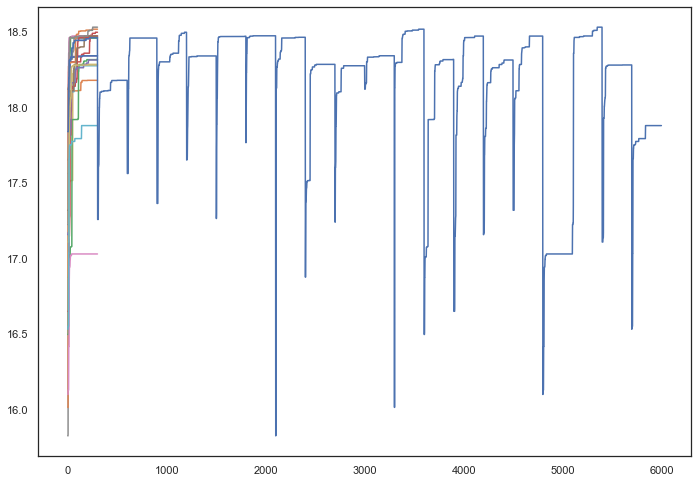

In [223]:
# Checagem
for file in os.listdir("./maximos"):
    df = pd.read_csv(f"./maximos/{file}")
    print (len(df))
    df["Pontuacao"].plot()

In [146]:
# Cria csv com historicos de todas as execucoes
criar_dataframe_historicos()

# Gráficos do Artigo

In [94]:
def cria_arquivo_stats():
    '''
    Desisti disso por enquanto
    '''
    df = pd.read_csv("historicos.csv", index_col=0)
    df["Total"] = df.apply(lambda x: x["Novas"] + x["Bloqueadas"], axis=1)
    df["Media Viavel"] = df.apply(lambda x: x["Novas"]/x["Total"], axis=1)
    df["Media Inviavel"] = df.apply(lambda x: x["Bloqueadas"]/x["Total"], axis=1)
    
    df = df.groupby("Grau").mean()
    
    df.index=["Segmented", "Linear", "Quadratic", "Cubic"]
    df = df.reset_index()
    df = df.rename(columns={"index": "Model"})
    df = df.drop("Tempo", axis=1)
    
    maxi = pd.read_csv("./maximos/max_compilado.csv")
    maxi = maxi.groupby("File").agg({"Pontuacao": ["mean", "max", "std"]}).reset_index()
    maxi = pd.concat([ maxi[["File"]], maxi["Pontuacao"]], axis=1)#.rename(columns = {"(File,)": "File"})
    maxi.columns = ["File", "mean", "max", "std"]
    maxi["Grau"] = maxi["File"].apply(lambda x: x.split("_")[2])
    maxi = maxi.groupby("Grau").mean()
    
    df["Maximum payload [kg]"] = maxi["max"]
    df["Mean payload [kg]"] = maxi["mean"]
    df["Standard deviation of payload [kg]"] = maxi["std"]
    
    df = df[ ['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'Media Viavel', 'des_via', 'Media Inviavel',
       'des_inv', 'med_tot', 'des_tot']]

    
    df.to_csv("stats.csv")
    return df

In [169]:
df= pd.read_csv("statspontin.csv")
df = df[['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_via', 'des_via', 'med_inv',
       'des_inv', 'med_tot', 'des_tot']]
df = df.T
df.columns = df.iloc[0]
df = df[1:4]
df

Model,Segmented,Linear,Quadratic,Cubic
Maximum payload [kg],18.4978,18.4744,18.5182,18.5315
Mean payload [kg],18.3879,18.3942,18.393,18.0386
Standard deviation of payload [kg],0.116971,0.0930033,0.0853713,0.554214


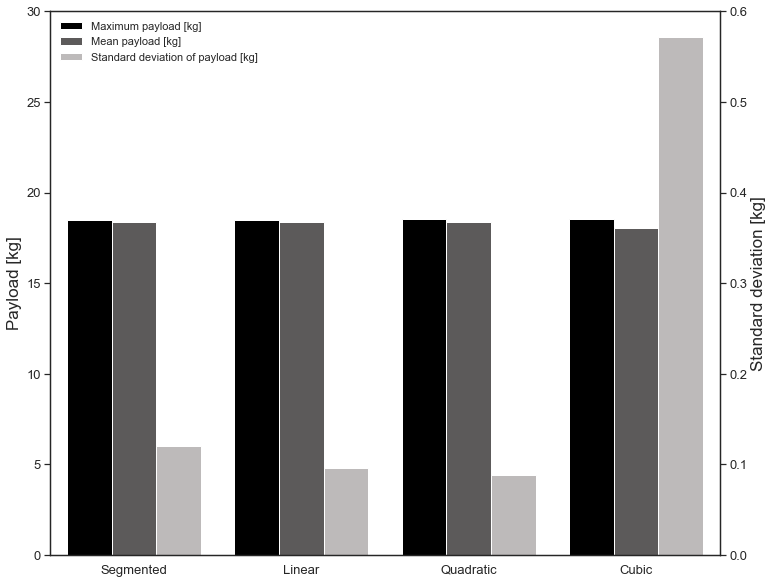

In [332]:
#PRepara dados

df= pd.read_csv("statspontin.csv")
df = df[['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_via', 'des_via', 'med_inv',
       'des_inv', 'med_tot', 'des_tot']]
df = df.T
df.columns = df.iloc[0]
df = df[1:4]
df[["Segmented","Linear","Quadratic","Cubic"]] = df[["Segmented","Linear","Quadratic","Cubic"]].apply(pd.to_numeric)
df = df.T
df = df.reset_index()
df = pd.melt(df, id_vars="Model", var_name="Stats", value_name="Valor")
df

# Gráfico de barras

# Scale the data, just a simple example of how you might determine the scaling
sns.set(rc={'figure.figsize':(11.7,8.27), 'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("white")
columns = ["Model", 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]']

mask = df.Stats.isin(['Standard deviation of payload [kg]'])

scale = int(df[~mask].Valor.mean()
            /df[mask].Valor.mean())

scale = scale*0.6

df.loc[mask, 'Valor'] = df.loc[mask, 'Valor']*scale

# Plot
fig, ax1 = plt.subplots(figsize=(12, 10))
g = sns.barplot(x=columns[0], y="Valor", hue="Stats",\
                data=df, ax=ax1,color="#445e6e", palette = ["#000000", "#5c5a5a", "#bdb9b9"])

# Create a second y-axis with the scaled ticks
ax1.set_ylabel('Payload [kg]',fontsize=17)
ax1.grid(False)
ax2 = ax1.twinx()

ax1.set_ylim([0,30])

ax2.set_ylim(ax1.get_ylim())
ax2.set_yticklabels(np.round(ax1.get_yticks()/scale,1))

ax2.set_ylabel('Standard deviation [kg]',fontsize=17)

ax2.grid(False)
ax1.set_xlabel('',fontsize=15)

ax2.tick_params(labelsize=13)
ax1.tick_params(labelsize=13)

ax1.legend().set_title('')

_ = ax1.legend(frameon=False)
# plt.show()xs.bar(bar_lefts, bar_heights, width=1.0, facecolor='black', edgecolor='black')
# plt.figure(figsize=(10,10))

# Outro gráfico

<Figure size 864x864 with 0 Axes>

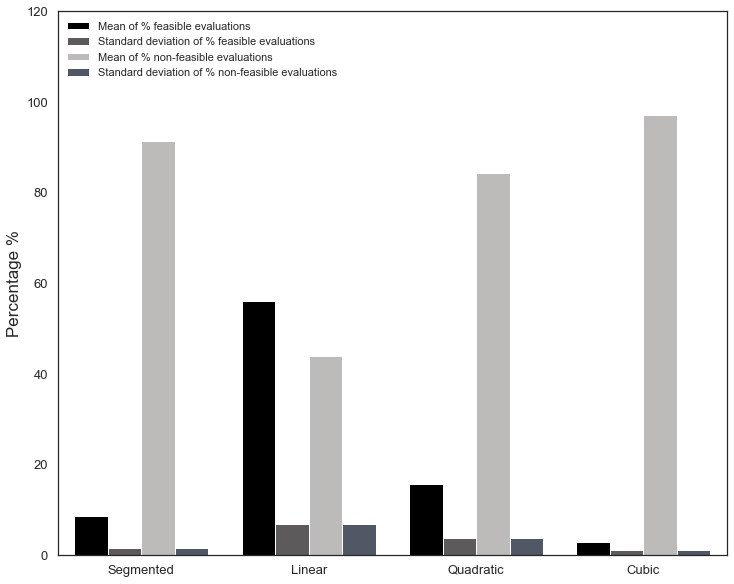

<Figure size 864x864 with 0 Axes>

<Figure size 864x864 with 0 Axes>

In [333]:
df= pd.read_csv("statspontin.csv")
df = df[['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_via', 'des_via', 'med_inv',
       'des_inv', 'med_tot', 'des_tot']]

df[["med_via","des_via","med_inv","des_inv"]] = df[["med_via","des_via","med_inv","des_inv"]].apply(lambda x: x*100)
df = df [['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_via', 'des_via', 'med_inv',
       'des_inv']]

df.columns = ['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 
            'Mean of % feasible evaluations', 
              'Standard deviation of % feasible evaluations', 
              "Mean of % non-feasible evaluations", 
              "Standard deviation of % non-feasible evaluations"]


df = df.T
df.columns = df.iloc[0]
df = df[4:]
df[["Segmented","Linear","Quadratic","Cubic"]] = df[["Segmented","Linear","Quadratic","Cubic"]].apply(pd.to_numeric)
df = df.T
df = df.reset_index()
df = pd.melt(df, id_vars="Model", var_name="Stats", value_name="Valor")

# Scale the data, just a simple example of how you might determine the scaling
sns.set(rc={'figure.figsize':(11.7,8.27), 'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("white")

columns = ["Model", "med_via","des_via","med_inv","des_inv",'med_tot', 'des_tot']

# scale =1

# Plot
fig, ax1 = plt.subplots(figsize=(12, 10))
g = sns.barplot(x=columns[0], y="Valor", hue="Stats",\
                data=df, ax=ax1,color="#445e6e", palette = ["#000000", "#5c5a5a", "#bdb9b9", "#4c5769"])
plt.figure(figsize=(12,12))
# ,color="#445e6e", palette = ["#000000", "#5c5a5a", "#bdb9b9"]

ax1.set_ylabel('Percentage %',fontsize=17)
ax1.grid(False)

ax1.set_ylim([0,120])

ax1.set_xlabel('',fontsize=15)

ax1.tick_params(labelsize=13)

ax1.legend(loc='upper left').set_title('')

_ = ax1.legend(frameon=False,loc='upper left')
plt.figure(figsize=(12,12))
# ax1.legend(bbox_to_anchor=(1.34, 1))

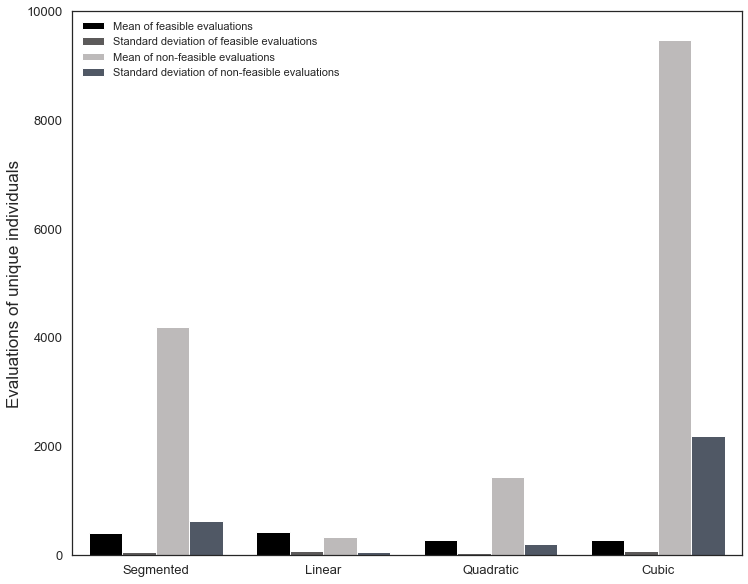

In [335]:
df= pd.read_csv("statspontin.csv")
df = df[['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_via', 'des_via', 'med_inv',
       'des_inv', 'med_tot', 'des_tot']]

df[["med_via","des_via","med_inv","des_inv"]] = df[["med_via","des_via","med_inv","des_inv"]].apply(lambda x: x*100)

df[['Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_via', 'des_via', 'med_inv',
       'des_inv', 'med_tot', 'des_tot']] = df[['Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_via', 'des_via', 'med_inv',
       'des_inv', 'med_tot', 'des_tot']].apply(pd.to_numeric)


df["med_viavel"] = df["med_tot"]*(df["med_via"]/100)
df["des_viavel"] = df["des_tot"]*(df["med_via"]/100)
df["med_inviavel"] = df["med_tot"]*(df["med_inv"]/100)
df["des_inviavel"] = df["des_tot"]*(df["med_inv"]/100)

df = df [['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 'med_viavel', 'des_viavel', "med_inviavel", "des_inviavel"]]
df.columns = ['Model', 'Maximum payload [kg]', 'Mean payload [kg]', 'Standard deviation of payload [kg]', 
              'Mean of feasible evaluations', 
              'Standard deviation of feasible evaluations', 
              "Mean of non-feasible evaluations", 
              "Standard deviation of non-feasible evaluations"]
df = df.T
df.columns = df.iloc[0]
df = df[4:]
df[["Segmented","Linear","Quadratic","Cubic"]] = df[["Segmented","Linear","Quadratic","Cubic"]].apply(pd.to_numeric)
df = df.T
df = df.reset_index()
df = pd.melt(df, id_vars="Model", var_name="Stats", value_name="Valor")

# Scale the data, just a simple example of how you might determine the scaling
sns.set(rc={'figure.figsize':(11.7,8.27), 'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.set_style("white")

columns = ["Model", "med_via","des_via","med_inv","des_inv",'med_tot', 'des_tot']

# scale =1

# Plot
fig, ax1 = plt.subplots(figsize=(12, 10))
g = sns.barplot(x=columns[0], y="Valor", hue="Stats",\
                data=df, ax=ax1,color="#445e6e", palette = ["#000000", "#5c5a5a", "#bdb9b9", "#4c5769"])

# ,color="#445e6e", palette = ["#000000", "#5c5a5a", "#bdb9b9"]

ax1.set_ylabel('Evaluations of unique individuals',fontsize=17)
ax1.grid(False)

ax1.set_ylim([0,10000])

ax1.set_xlabel('',fontsize=15)

ax1.tick_params(labelsize=13)

ax1.legend().set_title('')

_ = ax1.legend(frameon=False)

# ax1.legend(bbox_to_anchor=(1.24, 1))

18.531496425951346


Text(0, 0.5, 'Chord')

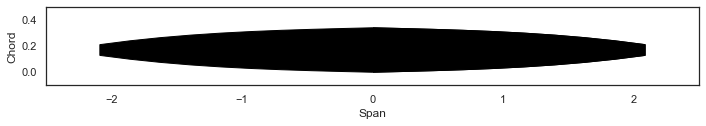

In [209]:
file = f"Cobem_poly_3_20_300_R3"
grau = file.split("_")[2]
path = f"grau={grau}/"+file
df = ler_logs(path)
df = df[df["viavel"]==0]
df = df.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()
print (df.iloc[299]["Pontuacao"])
plot_asa(df.iloc[299])
plt.xlim(-2.5, 2.5)
plt.ylim(-0.1, 0.5)
plt.xlabel("Span")
plt.ylabel("Chord")

In [185]:
# Melhores asas de cada grau
melhores = pd.DataFrame()
for file in os.listdir("./maximos"):
    df = pd.read_csv(f"./maximos/{file}")
    df = df.iloc[[299]]
    melhores = pd.concat([melhores, df])

In [186]:
melhores

,Geracao,Envergadura_1,Envergadura_2,Envergadura_3,Corda_1,Corda_2,Corda_3,Corda_4,Pontuacao,constraints,...,Chord_4,Chord_5,Chord_6,Chord_7,Chord_8,Chord_9,Chord_10,Chord_11,File,Execucao
299,299,0.3408,1.3968,2.0925,0.4744,0.35400,0.25900,0.11080,18.461951,"[4.1850000000000005, 1.056, 0.6957000000000002...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,299,0.3034,1.1248,2.0430,0.5608,0.32740,0.30080,0.10890,18.179334,"[4.086, 0.8214, 0.9182000000000001, 0.1089, -0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,299,0.3221,1.7856,2.0925,0.4744,0.36920,0.19060,0.05665,18.459522,"[4.1850000000000005, 1.4635, 0.306900000000000...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,299,0.3170,1.4080,2.0880,0.3952,0.35400,0.26375,0.13075,18.497811,"[4.176, 1.091, 0.6800000000000002, 0.13075, -0...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,299,0.4700,1.2688,2.0445,0.3880,0.34165,0.32740,0.07660,18.340816,"[4.089, 0.7988000000000002, 0.7757000000000001...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
299,299,0.6451,1.7840,2.0910,0.4717,0.17635,0.21815,0.17065,18.471373,"[4.182, 1.1388999999999998, 0.3070000000000004...",...,0.313974,0.291197,0.268420,0.245643,0.222865,0.200088,0.177311,0.154534,NaN,NaN
299,299,0.6417,1.3584,2.0925,0.5347,0.15830,0.24475,0.16780,18.474380,"[4.1850000000000005, 0.7167000000000001, 0.734...",...,0.332263,0.302693,0.273123,0.243553,0.213983,0.184413,0.154843,0.125273,NaN,NaN
299,299,0.3272,1.0608,2.0880,0.6400,0.14595,0.14880,0.23050,18.464549,"[4.176, 0.7336, 1.0272000000000001, 0.13690652...",...,0.322042,0.295594,0.269146,0.242698,0.216250,0.189802,0.163354,0.136907,NaN,NaN
299,299,0.3544,0.8560,2.0445,0.5320,0.18300,0.37965,0.12220,18.285077,"[4.089, 0.5016, 1.1885000000000003, 0.12369100...",...,0.333602,0.303615,0.273628,0.243640,0.213653,0.183666,0.153678,0.123691,NaN,NaN
299,299,0.3816,1.1776,2.0400,0.4600,0.31980,0.24950,0.15545,18.275850,"[4.08, 0.796, 0.8624, 0.14152023450874085, -0....",...,0.335227,0.307555,0.279882,0.252210,0.224538,0.196865,0.169193,0.141520,NaN,NaN


In [322]:
sns.set_style("ticks")
for grau in [0,1,2,3]:
    for file in os.listdir(f"./Resultados/grau={grau}"):
        if file.endswith(".csv"):
            print (file)
            path = f"grau={grau}/"+file
            df = ler_logs(path.split(".")[0])
            df = df[df['viavel']==0]
            maximo = df.sort_values(["Geracao","Pontuacao"]).groupby("Geracao").last()
            maximo = maximo[["Envergadura_3"]]
            maximo["Envergadura_3"] = maximo["Envergadura_3"]*2

            ax = maximo["Envergadura_3"].plot()

            plt.legend(["Execution 1", "Execution 2","Execution 3","Execution 4","Execution 5",],frameon=False, loc='lower right')

            plt.ylim(3,4.5)
    #         plt.grid()

            plt.yticks(np.arange(3, 5, 0.5))

            ax.set_xlabel("Generation",fontsize=17)
#             ax.set_ylabel('Wing Area $[m^{2}]$',fontsize=17)
            ax.set_ylabel('Wingspan [m]',fontsize=17)
            ax.tick_params(axis='y', which='minor', bottom=False)

            plt.savefig(f"gr{grau}-wingspan-gen.png")
    plt.clf()

Cobem_poly_0_20_300_R1.csv
Cobem_poly_0_20_300_R2.csv
Cobem_poly_0_20_300_R3.csv
Cobem_poly_0_20_300_R4.csv
Cobem_poly_0_20_300_R5.csv
Cobem_poly_1_20_300_R1.csv
Cobem_poly_1_20_300_R2.csv
Cobem_poly_1_20_300_R3.csv
Cobem_poly_1_20_300_R4.csv
Cobem_poly_1_20_300_R5.csv
Cobem_poly_2_20_300_R1.csv
Cobem_poly_2_20_300_R2.csv
Cobem_poly_2_20_300_R3.csv
Cobem_poly_2_20_300_R4.csv
Cobem_poly_2_20_300_R5.csv
Cobem_poly_3_20_300_R1.csv
Cobem_poly_3_20_300_R2.csv
Cobem_poly_3_20_300_R3.csv
Cobem_poly_3_20_300_R4.csv
Cobem_poly_3_20_300_R5.csv


<Figure size 842.4x595.44 with 0 Axes>

In [10]:
from itertools import permutations
  

In [26]:
a = [1,2,3,4]#.reverse()

In [29]:
a#.reverse()

[4, 3, 2, 1]